# Twitter text analysis
## This notebook describe steps for the following.
#### We get some data from twitter text and try to find out some 5/10 most important topic people are talking about. For each topic we try to find most important words. By showing those words we might get an idea on what people are talking about and that in turns might help business for taking some decisions.


## Import required python libraries

In [114]:
import tweepy
from datetime import datetime
import time
import twitter
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os.path
pd.options.display.max_colwidth = 500
import collections
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.sklearn
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.gensim  
from pprint import pprint
import gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

## Parameter inputs from users
#### With the below parameters this script will download twitter data with the keywords mentioned in 'searchQuery' and till date 'endUntil'. 
#### 'maxTweets' of records will be downloaded. 
#### As we are usng free tweeter API, sometimes this API doesnot allow us get data and cause connection error. Tetrying will work with 16000 records. 
#### With this api we cannot filter data with searchstring and location together. We can download whole data and later filter on location. But 1% of data has location rest has blank. Also we cannot get twitter data older than 7 days freely. Need to look for alternate location options
#### First time the download data will be saved as 'file_to_save' in directoryname 'dirname'. User can visualize top 'display_n_words' number of words 

In [111]:
# Twitter app credentials
consumer_key = 'naORWAQMry8zaFS3ToC5nkq61'
consumer_secret = 'wbDkwSYLXeduvCEKgOOkBye8WAwhr43Lxgg97wSH9hC1mROLiB'
access_token = '1251008034546974725-ANo5Zzq8jZaKbYpEt0gMh0IJQQ1Nrf'
access_secret = '26EXNB1T8JqWVM0j0PogmvsXMoMGHjMpFdvUzasL4hBaP'

# Tweet extraction criteria
maxTweets = 40000 # Some arbitrary large number, after 16000 its giving connection error
tweetsPerQry = 100  # this is the max the API permits
endUntil = '2020-04-20'  #till date tweet should be downloaded
since = '2020-04-16'  #since date
#"covid" OR "coronavirus" OR "covid-19" OR "virus"
# tweets containing texts to be downloaded
searchQuery = ' "#GAF" OR "#GAFRoofing" OR "#gafroofing" OR \
               "#RoofingExpo"  OR "#RoofingContractors" OR "#roofing" OR "GAF" OR "roof" OR "roofers" \
               OR "building" OR "shingles"'      #OR "TPO" OR "PVC" OR "SBS" OR "#TPA"'
lan='en'  #language
# name of the downloaded csv file
file_to_save='twitterdata.csv'
# directory where tweet tobe saved
dirname=r'C:\Users\suman12345678\Desktop\twitter\test\\'
#searchfor = ["covid","coronavirus","covid19","covid-19","virus","coronavirus","wuhan","corona","china","lockdown","quarntine","pandemic","helth","trump"]

# Data cleanning: words to ignore
mystopwords=['rt','https','cc']

# Visualize top n words 
display_n_words=15

## Download data using twitter REST api
#### This script will download record in keep in the drive mentioned above first time. If the file exist script will use it

In [ ]:
def create_api(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token=access_token,access_secret=access_secret):

   auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
   auth.set_access_token(access_token, access_secret)
   api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
   try:
        api.verify_credentials()
        #print('hi')
   except Exception as e:
        print('Please provide correct key',e)
   return api     
        
def get_data(api,searchQuery=searchQuery,endUntil=endUntil,lan=lan,file_to_save=file_to_save, dirname=dirname,fname=file_to_save):

    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -10000

    print(dirname+fname)
    if os.path.isfile(dirname+fname):
        data=pd.read_csv(dirname+fname)
        print('Already file available',data.shape)
        
        return data
    
    tweetCount = 0
    tweets=[]
    print("Downloading max {0} tweets".format(maxTweets))
    while tweetCount < maxTweets:
        try:
            # refer: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively./
            if (max_id <= 0):
                if (not sinceId): # first time
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True ) #, since=startSince)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, until=endUntil,lang=lan, result_type='recent',wait_on_rate_limit=True, wait_on_rate_limit_notify=True,  #,since=startSince, 
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
                
            for tweet in new_tweets:
                #print('\n\n\n',tweet)
                placeHolder = []
                placeHolder.append(tweet.author.name.encode('utf8'))
                placeHolder.append(tweet.author.screen_name.encode('utf8'))
                placeHolder.append(tweet.created_at)
                placeHolder.append(tweet.text)

                try:
                    placeHolder.append(tweet.place.full_name)
                    placeHolder.append(tweet.place.country)
                    placeHolder.append(tweet.place.place_type)
                except:
                    placeHolder.append('')
                    placeHolder.append('')
                    placeHolder.append('')

                placeHolder.append(tweet.user.location)
                placeHolder.append(tweet.geo)

                tweets.append(placeHolder)

            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        #except tweepy.TweepError as e:
        #    print("some error : " + str(e))
        #    break
        # refer: https://stackoverflow.com/questions/21308762/avoid-twitter-api-limitation-with-tweepy
        except tweepy.TweepError as e:
            #time.sleep(60 * 2)
            print('continuing after waiting...')
            continue
        except StopIteration:
            break

    data=pd.DataFrame(data=tweets, columns=['Author','Screenname','Created','text','place_name','country','place_type','user_location','user_geo_loc'])
    #data.to_csv(dirname+file_to_save)
    return data

api=create_api(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token=access_token,access_secret=access_secret)

cur_extract=endUntil



final_data=pd.DataFrame()
while(cur_extract>=since):
    print('extract',cur_extract)
    data=get_data(api=api,searchQuery=searchQuery,endUntil=cur_extract,lan=lan,file_to_save=file_to_save, dirname=dirname)
    print(data.shape)
    cur_extract=(datetime.strptime(cur_extract,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    final_data=pd.concat([final_data,data])
final_data.to_csv(dirname+file_to_save)    
  
    
#data=get_data(api=api,searchQuery=searchQuery,endUntil=endUntil,lan=lan,file_to_save=file_to_save, dirname=dirname)

extract 2020-04-20
C:\Users\suman12345678\Desktop\twitter\test\\twitterdata.csv
Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets
Downloaded 2100 tweets
Downloaded 2200 tweets
Downloaded 2300 tweets
Downloaded 2400 tweets
Downloaded 2500 tweets
Downloaded 2600 tweets
Downloaded 2700 tweets
Downloaded 2800 tweets
Downloaded 2900 tweets
Downloaded 3000 tweets
Downloaded 3100 tweets
Downloaded 3200 tweets
Downloaded 3300 tweets
Downloaded 3400 tweets
Downloaded 3500 tweets
Downloaded 3600 tweets
Downloaded 3700 tweets
Downloaded 3800 tweets
Downloaded 3900 tweets
Downloaded 4000 tweets
Downloade

Downloaded 18100 tweets
Downloaded 18200 tweets
Downloaded 18300 tweets
Downloaded 18400 tweets
Downloaded 18499 tweets
Downloaded 18599 tweets
Downloaded 18699 tweets
Downloaded 18799 tweets
Downloaded 18899 tweets
Downloaded 18999 tweets
Downloaded 19099 tweets
Downloaded 19199 tweets
Downloaded 19299 tweets
Downloaded 19399 tweets
Downloaded 19499 tweets
Downloaded 19599 tweets
Downloaded 19699 tweets
Downloaded 19799 tweets
Downloaded 19899 tweets
Downloaded 19999 tweets
Downloaded 20099 tweets
Downloaded 20199 tweets
Downloaded 20299 tweets
Downloaded 20399 tweets
Downloaded 20499 tweets
Downloaded 20599 tweets
Downloaded 20699 tweets
Downloaded 20799 tweets
Downloaded 20899 tweets


In [94]:
endUntil = '2020-04-20'  #till date tweet should be downloaded
since = '2020-04-16'  #since date

cur_extract=endUntil
while(cur_extract>=since):
    print('extract',cur_extract)
    cur_extract=(datetime.strptime(cur_extract,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')


extract 2020-04-20
extract 2020-04-19
extract 2020-04-18
extract 2020-04-17
extract 2020-04-16


In [110]:
print('Total no of data',final_data.shape[0])
print('No of data where user location available',final_data['user_location'].value_counts()[0])


Total no of data 1000
No of data where user location available 349


In [51]:
data['country'].value_counts()

United States                  312
United Kingdom                  25
Canada                          23
Australia                       12
Nigeria                         11
Ireland                          6
India                            5
Republic of the Philippines      4
New Zealand                      3
South Africa                     2
Singapore                        2
Uruguay                          2
Malaysia                         1
Norway                           1
Cameroon                         1
Zimbabwe                         1
Barbados                         1
Kingdom of Saudi Arabia          1
Grenada                          1
Italy                            1
Papua New Guinea                 1
United Arab Emirates             1
Zambia                           1
Name: country, dtype: int64

## Apply required extra filter on downloaded data from twitter


In [54]:
#places = api.geo_search(query="USA", granularity="country")
#place_id = places[0].id


In [55]:
# we can get only last 1 week data
#temp=data.copy()
#temp['Created_dt']=temp['Created'].apply(lambda x: pd.to_datetime(x).date())
#temp=temp[temp['Created_dt'].astype('str')=='2020-04-19']
#temp=temp.drop_duplicates(subset={'text'})

## Cleanning text data before getting insights

In [69]:
# Display one duplicate
print(data.sort_values('text')['text'][:5])  # some instances of duplicate
print('no of unique sentences',len(data['text'].unique()))

25161                                              !!!!!!!!!!!!!!!! he swore he don’t gaf everyone says that but now look smh https://t.co/RzUBttJ6Yd
23662    " chief why are you even here i don't understand something about ONI don't feel right i mean look they have every S… https://t.co/taV9Rz1ScO
32420    "'Animal Crossing’ is an opportunity for a person to create a new society on a deserted island and to kind of creat… https://t.co/G8tPmUARLm
27769    "...Alkira’s team has the ambitious vision to disrupt the status quo, and a proven track record building enduring c… https://t.co/g403mxm2NT
9727     "...to everyone around us, we should be asking the question, what are you building? What are you building directly,… https://t.co/9WPZrJoyNw
Name: text, dtype: object
no of unique sentences 16235


#### Remove duplicate text, convert to lowercase, create a column with the hashtag used

In [70]:
# Drop duplicate
textdata=data.drop_duplicates(subset={'text'})
print(textdata.shape)

textdata=textdata.copy()

#convert to lower
textdata['text']=textdata['text'].apply(lambda x: x.lower()).copy()

# find hashtag
textdata['tag']=textdata['text'].apply(lambda x: re.findall(r"#(\w+)", x)).copy()

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

(16235, 10)
No of unique words 60386


In [71]:
# remove words covid related as those are dominating string
#textdata=textdata.copy()
#textdata = textdata[~textdata.text.str.contains('|'.join(searchfor))]
print('Shape of df',textdata.shape)                    

Shape of df (16235, 11)


In [72]:
textdata['text'].head(5)

0     @itsafez66 last week i heard fireworks forever and was like jfc calm down but then i got a citizen alert and it tur… https://t.co/grgcsdef5c
1     simply put, they are the actual building blocks of that wardrobe you’ve been dreaming about. they are actually thos… https://t.co/h4fphksn5a
2    @sbarutta @jchannah77 @siobhanbenita @trevor_stables "these people" are we now.\n\nboth of those concepts are really… https://t.co/vvnzjwpt9x
3                                                                    rt @jerm_cohen: roof culture during quarantine in nyc https://t.co/uo2trehemu
4      rt @naval: the swedish approach allows us to measure the cost of building herd immunity using partial and voluntary measures rather than a…
Name: text, dtype: object

#### Remove website names, remove the names whome text was retweeted, removed punctuations, digits, removed english stopwords, kept only alphabetic chracters, used lemmetization(original form of words : cats--> cat)

In [73]:
textdata=textdata.copy()

#remove website name
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
                                        
#remove RT retweet to subject
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'@(\w+)', r'', x))

# clean punc
def cleanpuncdigit(sentence):
    #cleaned=re.sub(r'[-|[|]|.|,|:|\|/|?|!|\'|"|#]',r' ',sentence)
    cleaned=re.sub(r'[-|\|(|)|.|,|:|/|?|!|\'|"|#]',r' ',sentence)
    cleaned=re.sub(r'[\d+]',r' ',cleaned)    
    return cleaned
textdata['text']=textdata['text'].apply(cleanpuncdigit)

#remove stopwords
stop=set(stopwords.words('english'))
stop.update(mystopwords)
textdata['text']=textdata['text'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words before stem',len(set([item for sublist in l for item in sublist])))

# Stemming this is not giving correct words so commenting
#sno=nltk.stem.snowball.SnowballStemmer('english')
#textdata['text'] = textdata['text'].apply(lambda x: ' '.join([sno.stem(y) for y in x.split()])) # Stem every word.
#sno.stem('coming come programers programer, programming going')

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after stemming',len(set([item for sublist in l for item in sublist])))

# keep only alphabetic character remove whitespace
textdata['text']=textdata['text'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
textdata['text']=textdata['text'].apply(lambda x: x.strip())

# Lemmetization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
textdata['text']=textdata['text'].apply(lemmatize_text)

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words after lemetization',len(set([item for sublist in l for item in sublist])))

No of unique words before stem 25531
No of unique words after stemming 25531
No of unique words after lemetization 19640


In [74]:
l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

No of unique words 19640


In [75]:
textdata['text'].head(10)

0                                       last week heard firework forever like jfc calm got citizen alert tur
1                                     simply put actual building block wardrobe you ve dreaming actually tho
2                                                                                      people concept really
3                                                                                roof culture quarantine nyc
4     swedish approach allows u measure cost building herd immunity using partial voluntary measure rather a
5                                      pure magic blowing roof next gen game ontario rewind leafsforever htt
6                                                                            oh shit y all mr nigga building
10                                                       si building credit si bag si minding business si si
13                            never ask vampire favor f get involved wizard always pay attention exactly the
16                 

#### Filter the texts with word roof


In [76]:
textdata[textdata.text.str.contains('|'.join(['roof','roofing']))]['text'].head(5)

3                                                                      roof culture quarantine nyc
5                            pure magic blowing roof next gen game ontario rewind leafsforever htt
20    gentrification roof culture quarantine nyc landlord amp cop stopped hood accessing roof deca
90                                                                                   yell roof top
95                                 sigh building dey practice social distancing first instead roof
Name: text, dtype: object

## Visualize text data
#### Most used tag

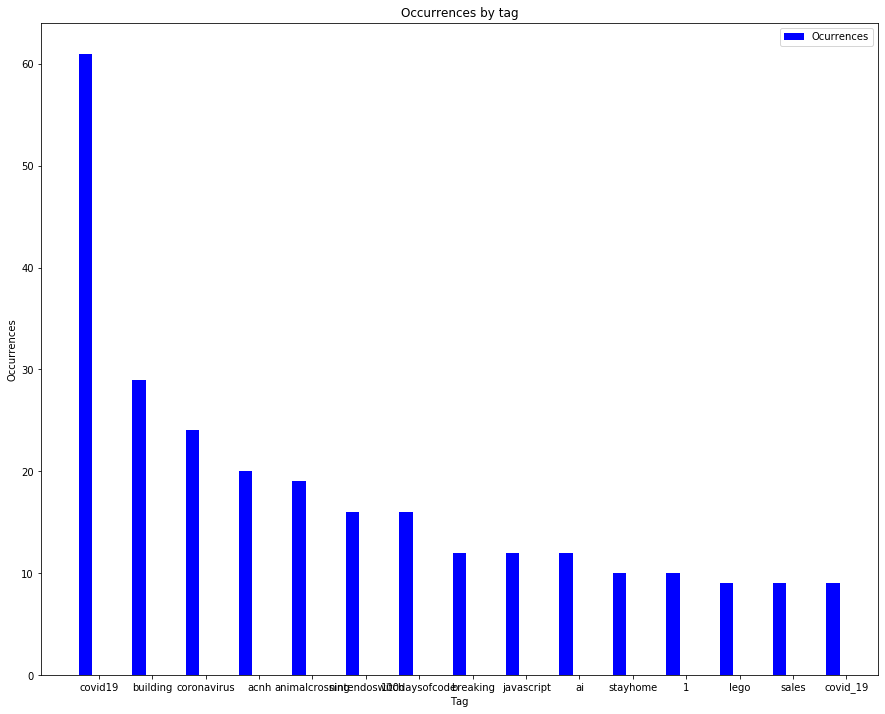

In [77]:
# Count frequency of words
tags=textdata['tag'].tolist()
tags= [item for sublist in tags for item in sublist]
counter=collections.Counter(tags)
display_n_words=15
counter_data=counter.most_common(display_n_words)

# Plot most used tags
n_groups = len(counter_data)

vals_films = [x[1] for x in counter_data]
legends_films = [x[0] for x in counter_data]
index = np.arange(n_groups)
bar_width = 0.25


fig, ax = plt.subplots(figsize=(15,12))
plt.xlabel('Tag')
plt.bar(index, vals_films, bar_width,color='b',label='Ocurrences')
plt.ylabel('Occurrences')
plt.title('Occurrences by tag')
plt.xticks(index + bar_width, legends_films)
plt.legend()

#### Show words most used in tweeter bigger size==more used

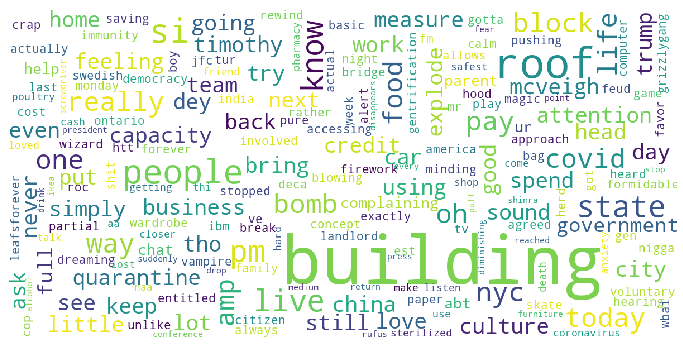

In [78]:
# create wordcloud
stopwords_set = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords_set,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(textdata['text'])

#### Datewise total tweet

In [80]:
textdata['Created_dt']=textdata['Created'].apply(lambda x: pd.to_datetime(x).date())
#fig, ax = plt.subplots(figsize=(15,12))
#plt.xlabel('Dates')
#plt.ylabel('Occurrences')
#textdata['Created_dt'].value_counts().plot(ax=ax, kind='bar')
#plt.title('Occurrences by date')
#plt.legend()

## ML model
#### Here we are trying to get the most discussed topic in twitter. Say we want to identify 10 topic across the data available in twitter for the searchstrings. Once we get the topics we will show the top 10 important words of each topics. By displaying those top 10 words in each topic we can get some idea what people are talking about in twitter which might benifit the business.

## Create vector form of text data
#### We convert text to vector for applying machine learning model

In [81]:
# Initialise the count vectorizer
count_vectorizer = CountVectorizer(min_df = 3)

# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(textdata['text'])

# Initialise the tfidf vectorizer 
tfidf_vectorizer = TfidfVectorizer(min_df=2)

# Fit and transform the processed text
tfidf_data = tfidf_vectorizer.fit_transform(textdata['text'])

### Hyperparameter for 3 models user input this is for tunning for ML model

In [82]:
search_params_lda = {'n_components': [4,5,8,10], 'learning_decay': [.2,.5,.8]} # with 10 n_component model perplexity 20000
search_params_nmf = {'n_components': [4,5,8,10], 'alpha':[0.0,.1,.2,.5], 'l1_ratio':[0.0,.1,.3,.5]} # with 10 n_component model perplexity 20000
search_params_gensim={'num_topics':[4,5,8,10],'alpha':['asymmetric','auto',.1,.3,.5],'eta':[.1,.3,.5]}               


## Use LDA model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

Best model's params:  {'learning_decay': 0.2, 'n_components': 4}
Best log likelihood score:  -216892.05751665952
Model perplexity:  2289.179618442937
Using best model below are topics and top n words

Topic #0:
roof building like day get amp people going go today head top family would good

Topic #1:
building gaf new like get back don amp need year really one love it world

Topic #2:
building one know people day time every go see make week it month apartment sure

Topic #3:
building fire build music time amp team work moody people great today city still see


C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


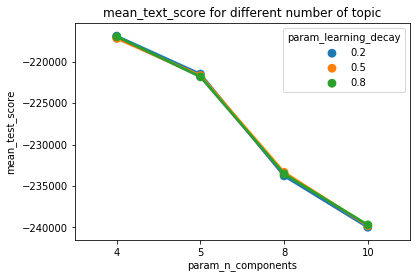

In [28]:
# do grid search and return best model for LDA
def modelcall(model_name,data,search_params):
    model = GridSearchCV(model_name, search_params)
    model.fit(data)   
    best_lda_model = model.best_estimator_
    print("Best model's params: ", model.best_params_)
    print("Best log likelihood score: ", model.best_score_)
    print("Model perplexity: ", best_lda_model.perplexity(data))
    return model

def model_score(model,count_vectorizer,count_data,n_top_words=15):

    # Topic - Keyword matrix
    best_lda_model = model.best_estimator_
    df_topic_keywords = pd.DataFrame(best_lda_model.components_)

    # assign column and index
    df_topic_keywords.columns = count_vectorizer.get_feature_names()
    topicnames = ['Topic_' + str(i) for i in range(best_lda_model.n_components)]
    df_topic_keywords.index = topicnames
    
    words = count_vectorizer.get_feature_names()
    print('Using best model below are topics and top n words')
    for topic_idx, topic in enumerate(best_lda_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))    

    # check the head
    df_topic_keywords.iloc[:,:10]

    df_cv_results = pd.DataFrame(model.cv_results_)
    
    # plot cross validation result
    sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results).set_title('mean_text_score for different number of topic')
    
    # refered from https://shravan-kuchkula.github.io/topic-modeling/#appendix
    best_lda_model = model.best_estimator_
    panel = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')
    vis=pyLDAvis.display(panel)
    return vis

#search_params_lda = {'n_components': [5], 'learning_decay': [.2]}  # with n_component=10 model_perplexity 2550. Lowest perplexity is best
model_name = LDA( n_jobs=-1)
final_model_lda_cv=modelcall(model_name,count_data,search_params_lda)
vis=model_score(final_model_lda_cv,count_vectorizer,count_data,n_top_words=display_n_words)
vis

#### Use tfidf
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

In [83]:
model_name = LDA(n_jobs=-1)
final_model_lda_tf=modelcall(model_name,tfidf_data,search_params_lda)
vis=model_score(final_model_lda_tf,tfidf_vectorizer,tfidf_data)
vis

KeyboardInterrupt: 

## Use NMF(Non Matrix factorization) model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time

In [ ]:


# Grid search
def gridsearch_nmf(search_params,count_data,count_vectorizer,n_top_words):
    error=1000000

    for i in search_params['n_components']:
        for j in search_params['alpha']:
            for k in search_params['l1_ratio']:
                #print('for ',i,j,k)
                model_name=NMF(n_components=i,alpha=j,l1_ratio=k)
                model_name.fit(count_data)
                #print(model_name.reconstruction_err_)
                if model_name.reconstruction_err_<error:
                    error=model_name.reconstruction_err_
                    #print('Better model',model_name.reconstruction_err_,i,j,k)
                    final_model=model_name
    words = count_vectorizer.get_feature_names()
    print('From grid search best model reconstraction error',final_model.reconstruction_err_,' with number of topic ',final_model.n_components)
    print('For best model topics and top n words with their weights')
    for topic_idx, topic in enumerate(final_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]+" "+str(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))   
        
    return final_model
    
        
#search_params = {'n_components': [5], 'alpha':[0.0], 'l1_ratio':[0.0]} # with 10 n_component model perplexity 20000
final_model_nmf_cv=gridsearch_nmf(search_params=search_params_nmf,count_data=count_data,count_vectorizer=count_vectorizer,n_top_words=display_n_words)


#### tfidf vectorizer
#### Careful: Below steps will take time

In [ ]:

final_model_nmf_tf=gridsearch_nmf(search_params=search_params_nmf,count_data=tfidf_data,count_vectorizer=tfidf_vectorizer,n_top_words=display_n_words)


    
## Use gensim model    
#### Create text corpus

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(textdata['text']))

print(data_words[:1])

id2word = corpora.Dictionary(data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# View
print(corpus[:1])

[['last', 'week', 'heard', 'firework', 'forever', 'like', 'jfc', 'calm', 'got', 'citizen', 'alert', 'tur']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


#### Grid search
#### Careful: Below steps will take time

In [103]:
def gensin_gs(search_params,corpus,data_words):
    perplixity=100000
    coherance=0
    for i in search_params['num_topics']:
        for j in search_params['alpha']:
                for k in search_params['eta']:
                        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=j,
                                           eta=k,                         
                                           per_word_topics=True)
                        doc_lda = lda_model[corpus]
                        
                        # Compute Coherence Score
                        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
                        # compute perplexist
                        ps=lda_model.log_perplexity(corpus)
                        with np.errstate(invalid='ignore'):
                            coherence_lda = coherence_model_lda.get_coherence()
                        print('/n/nFor topics, alpha, eta values : ',i,j,k)    
                        print('Perplexity: ', ps,'\nCoherence Score: ', coherence_lda)  # a measure of how good the model is. lower the better.

                        if (coherence_lda>coherance):  # & (ps <perplixity):
                            final_model=lda_model

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

    return final_model, vis    

final_model_gensim,vis=gensin_gs(search_params_gensim,corpus,data_words)
vis


For topics, alpha, eta values :  4 asymmetric 0.1

Perplexity:  -9.96894573247836 
Coherence Score:  0.3069228627436199
For topics, alpha, eta values :  4 asymmetric 0.3

Perplexity:  -8.895012959262083 
Coherence Score:  0.2708741673565695
For topics, alpha, eta values :  4 asymmetric 0.5

Perplexity:  -8.762489060646198 
Coherence Score:  0.31458931225090586
For topics, alpha, eta values :  4 auto 0.1

Perplexity:  -9.865686608772185 
Coherence Score:  0.2333492111634092
For topics, alpha, eta values :  4 auto 0.3

Perplexity:  -8.84109618412052 
Coherence Score:  0.2338356903968523
For topics, alpha, eta values :  4 auto 0.5

Perplexity:  -8.686816682100794 
Coherence Score:  0.42008277292274704
For topics, alpha, eta values :  4 0.1 0.1

Perplexity:  -10.078351290876933 
Coherence Score:  0.21983187712191665
For topics, alpha, eta values :  4 0.1 0.3

Perplexity:  -8.997744397639687 
Coherence Score:  0.22509096880660484
For topics, alpha, eta values :  4 0.1 0.5

Perplexity:  -8.8

C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

In [26]:
final_model_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
                                           update_every=1,chunksize=100,passes=10,alpha='auto',eta=.5, per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_model_gensim, corpus, id2word)
vis
    
#Perplexity:  -8.613900273756974 
#Coherence Score:  0.6543220291600722
#For topics, alpha, eta values :  10 0.1 0.1    
    

C:\Users\suman12345678\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.302046  0.004785       1        1  78.076935
9     -0.001356 -0.030579       2        1  10.451492
1      0.025199 -0.012025       3        1   4.700866
0      0.032984 -0.007260       4        1   2.618254
8      0.037790 -0.001116       5        1   1.325786
6      0.038229 -0.000244       6        1   1.217919
3      0.040478  0.005344       7        1   0.717160
4      0.041476  0.008438       8        1   0.527085
2      0.042678  0.012625       9        1   0.325324
5      0.044567  0.020033      10        1   0.039176, topic_info=      Category         Freq          Term        Total  loglift  logprob
15     Default  7124.000000      building  7124.000000  30.0000  30.0000
29     Default  1931.000000          roof  1931.000000  29.0000  29.0000
9      Default   783.000000          like   783.000000  28.0000  28.0000
134    Default   684.000000           one   684.000000  27.0000  27.0000
735    Default   576.000000           new   576.000000  26.0000  26.0000
24     Default   559.000000        people   559.000000  25.0000  25.0000
66     Default   550.000000           get   550.000000  24.0000  24.0000
94     Default   521.000000           amp   521.000000  23.0000  23.0000
216    Default   507.000000          time   507.000000  22.0000  22.0000
535    Default   434.000000           gaf   434.000000  21.0000  21.0000
585    Default   437.000000           day   437.000000  20.0000  20.0000
395    Default   420.000000            it   420.000000  19.0000  19.0000
301    Default   419.000000            go   419.000000  18.0000  18.0000
133    Default   378.000000         going   378.000000  17.0000  17.0000
261    Default   374.000000           don   374.000000  16.0000  16.0000
202    Default   355.000000          year   355.000000  15.0000  15.0000
106    Default   340.000000          work   340.000000  14.0000  14.0000
570    Default   335.000000         think   335.000000  13.0000  13.0000
278    Default   329.000000         would   329.000000  12.0000  12.0000
115    Default   332.000000          make   332.000000  11.0000  11.0000
114    Default   319.000000          know   319.000000  10.0000  10.0000
25     Default   317.000000        really   317.000000   9.0000   9.0000
5      Default   296.000000           got   296.000000   8.0000   8.0000
902    Default   301.000000         house   301.000000   7.0000   7.0000
530    Default   280.000000          need   280.000000   6.0000   6.0000
307    Default   294.000000           way   294.000000   5.0000   5.0000
414    Default   293.000000         right   293.000000   4.0000   4.0000
720    Default   280.000000         thing   280.000000   3.0000   3.0000
199    Default   269.000000         today   269.000000   2.0000   2.0000
82     Default   281.000000           see   281.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
9523   Topic10     0.002956            ka    16.506130  -0.7827  -9.8301
9481   Topic10     0.002956           hai    16.564623  -0.7863  -9.8302
12508  Topic10     0.002956       allston    16.643286  -0.7910  -9.8302
9242   Topic10     0.002955         pussy    17.304371  -0.8302  -9.8305
5542   Topic10     0.002954       hangout    13.655493  -0.5940  -9.8310
18648  Topic10     0.002954       eijirou    13.617096  -0.5912  -9.8311
18608  Topic10     0.002952  indieartists    12.678452  -0.5204  -9.8317
18216  Topic10     0.002952     palestine    12.652123  -0.5184  -9.8317
1748   Topic10     0.002952        temple    18.102724  -0.8766  -9.8318
14109  Topic10     0.002951    skyscraper    13.970518  -0.6175  -9.8318
18538  Topic10     0.002950        vacate    11.812696  -0.4502  -9.8323
18544  Topic10     0.002950           ber    11.790085  -0.4483  -9.8323
18531  Topic10     0.002950            db    11.835096  -0.4522  -9.8323
3163   Topic10     0.002

## Conclusions
#### This is done with few data considering laptop configurations, with more data the performance will be better
#### The Twitter free api has some limitations for our easy filterring direct use, But all filter can be used once we download whole data
#### Depanding on good selection of text we are looking in twitter the performance of model will improve
#### Here we are trying to identify topics discussed in twitter, we can also use some other Machile learning algorithm to help business